# Double Texting

Seamless handling of [double texting](https://docs.langchain.com/langsmith/double-texting) is important for handling real-world usage scenarios, especially in chat applications.

Users can send multiple messages in a row before the prior run(s) complete, and we want to ensure that we handle this gracefully.

## Reject

A simple approach is to [reject](https://docs.langchain.com/langsmith/reject-concurrent) any new runs until the current run completes.

In [13]:
%%capture --no-stderr
%pip install -U langgraph_sdk

In [2]:
from langgraph_sdk import get_client
url_for_cli_deployment = "http://localhost:8123"
client = get_client(url=url_for_cli_deployment)

In [18]:
import httpx
from langchain_core.messages import HumanMessage

# Create a thread
thread = await client.threads.create()

# Create to dos
user_input_1 = "Add a ToDo to follow-up with DI Repairs."
user_input_2 = "Add a ToDo to mount dresser to the wall."
config = {"configurable": {"user_id": "Test-Double-Texting"}}
graph_name = "task_maistro" 

run = await client.runs.create(
    thread["thread_id"],
    graph_name,
    input={"messages": [HumanMessage(content=user_input_1)]}, 
    config=config,
)
try:
    await client.runs.create(
        thread["thread_id"],
        graph_name,
        input={"messages": [HumanMessage(content=user_input_2)]}, 
        config=config,
        multitask_strategy="reject",
    )
except httpx.HTTPStatusError as e:
    print("Failed to start concurrent run", e)

Failed to start concurrent run Client error '409 Conflict' for url 'http://localhost:8123/threads/2b58630e-00fd-4c35-afad-a6b59e9b9104/runs'
For more information check: https://developer.mozilla.org/en-US/docs/Web/HTTP/Status/409


In [19]:
from langchain_core.messages import convert_to_messages

# Wait until the original run completes
await client.runs.join(thread["thread_id"], run["run_id"])

# Get the state of the thread
state = await client.threads.get_state(thread["thread_id"])
for m in convert_to_messages(state["values"]["messages"]):
    m.pretty_print()

================================ Human Message =================================

Add a ToDo to follow-up with DI Repairs.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_6xqHubCPNufS0bg4tbUxC0FU)
 Call ID: call_6xqHubCPNufS0bg4tbUxC0FU
  Args:
    update_type: todo
================================= Tool Message =================================

New ToDo created:
Content: {'task': 'Follow-up with DI Repairs', 'time_to_complete': 30, 'deadline': None, 'solutions': ['Call DI Repairs customer service', 'Email DI Repairs support', 'Check DI Repairs website for updates'], 'status': 'not started'}
================================== Ai Message ==================================

I've added a task to follow-up with DI Repairs to your ToDo list. If there's anything else you need, feel free to let me know!


## Enqueue

We can use [enqueue](https://docs.langchain.com/langsmith/enqueue-concurrent) any new runs until the current run completes.

In [20]:
# Create a new thread
thread = await client.threads.create()

# Create new ToDos
user_input_1 = "Send Erik his t-shirt gift this weekend."
user_input_2 = "Get cash and pay nanny for 2 weeks. Do this by Friday."
config = {"configurable": {"user_id": "Test-Double-Texting"}}
graph_name = "task_maistro" 

first_run = await client.runs.create(
    thread["thread_id"],
    graph_name,
    input={"messages": [HumanMessage(content=user_input_1)]}, 
    config=config,
)

second_run = await client.runs.create(
    thread["thread_id"],
    graph_name,
    input={"messages": [HumanMessage(content=user_input_2)]}, 
    config=config,
    multitask_strategy="enqueue",
)

# Wait until the second run completes
await client.runs.join(thread["thread_id"], second_run["run_id"])

# Get the state of the thread
state = await client.threads.get_state(thread["thread_id"])
for m in convert_to_messages(state["values"]["messages"]):
    m.pretty_print()

================================ Human Message =================================

Send Erik his t-shirt gift this weekend.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_svTeXPmWGTLY8aQ8EifjwHAa)
 Call ID: call_svTeXPmWGTLY8aQ8EifjwHAa
  Args:
    update_type: todo
================================= Tool Message =================================

New ToDo created:
Content: {'task': 'Send Erik his t-shirt gift', 'time_to_complete': 30, 'deadline': '2024-11-19T23:59:00', 'solutions': ['Wrap the t-shirt', "Get Erik's address", 'Visit the post office', 'Choose a delivery service'], 'status': 'not started'}
================================== Ai Message ==================================

I've updated your ToDo list to send Erik his t-shirt gift this weekend. If there's anything else you need, feel free to let me know!
================================ Human Message =================================

Get cash and pay nanny for 

## Interrupt

We can use [interrupt](https://docs.langchain.com/langsmith/interrupt-concurrent) to interrupt the current run, but save all the work that has been done so far up to that point.


In [32]:
import asyncio

# Create a new thread
thread = await client.threads.create()

# Create new ToDos
user_input_1 = "Give me a summary of my ToDos due tomrrow."
user_input_2 = "Never mind, create a ToDo to Order Ham for Thanksgiving by next Friday."
config = {"configurable": {"user_id": "Test-Double-Texting"}}
graph_name = "task_maistro" 

interrupted_run = await client.runs.create(
    thread["thread_id"],
    graph_name,
    input={"messages": [HumanMessage(content=user_input_1)]}, 
    config=config,
)

# Wait for some of run 1 to complete so that we can see it in the thread 
await asyncio.sleep(1)

second_run = await client.runs.create(
    thread["thread_id"],
    graph_name,
    input={"messages": [HumanMessage(content=user_input_2)]}, 
    config=config,
    multitask_strategy="interrupt",
)

# Wait until the second run completes
await client.runs.join(thread["thread_id"], second_run["run_id"])

# Get the state of the thread
state = await client.threads.get_state(thread["thread_id"])
for m in convert_to_messages(state["values"]["messages"]):
    m.pretty_print()

================================ Human Message =================================

Give me a summary of my ToDos due tomrrow.
================================ Human Message =================================

Never mind, create a ToDo to Order Ham for Thanksgiving by next Friday.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_Rk80tTSJzik2oY44tyUWk8FM)
 Call ID: call_Rk80tTSJzik2oY44tyUWk8FM
  Args:
    update_type: todo
================================= Tool Message =================================

New ToDo created:
Content: {'task': 'Order Ham for Thanksgiving', 'time_to_complete': 30, 'deadline': '2024-11-22T23:59:59', 'solutions': ['Check local grocery stores for availability', 'Order online from a specialty meat provider', 'Visit a local butcher shop'], 'status': 'not started'}
================================== Ai Message ==================================

I've added the task "Order Ham for Thanksgiving" to your T

We can see the initial run is saved, and has status `interrupted`.

In [33]:
# Confirm that the first run was interrupted
print((await client.runs.get(thread["thread_id"], interrupted_run["run_id"]))["status"])

interrupted


## Rollback

We can use [rollback](https://docs.langchain.com/langsmith/rollback-concurrent) to interrupt the prior run of the graph, delete it, and start a new run with the double-texted input.


In [28]:
# Create a new thread
thread = await client.threads.create()

# Create new ToDos
user_input_1 = "Add a ToDo to call to make appointment at Yoga."
user_input_2 = "Actually, add a ToDo to drop by Yoga in person on Sunday."
config = {"configurable": {"user_id": "Test-Double-Texting"}}
graph_name = "task_maistro" 

rolled_back_run = await client.runs.create(
    thread["thread_id"],
    graph_name,
    input={"messages": [HumanMessage(content=user_input_1)]}, 
    config=config,
)

second_run = await client.runs.create(
    thread["thread_id"],
    graph_name,
    input={"messages": [HumanMessage(content=user_input_2)]}, 
    config=config,
    multitask_strategy="rollback",
)

# Wait until the second run completes
await client.runs.join(thread["thread_id"], second_run["run_id"])

# Get the state of the thread
state = await client.threads.get_state(thread["thread_id"])
for m in convert_to_messages(state["values"]["messages"]):
    m.pretty_print()

================================ Human Message =================================

Actually, add a ToDo to drop by Yoga in person on Sunday.
================================== Ai Message ==================================

It looks like the task "Drop by Yoga in person" is already on your ToDo list with a deadline of November 19, 2024. Would you like me to update the deadline to the upcoming Sunday instead?


The initial run was deleted.

In [29]:
# Confirm that the original run was deleted
try:
    await client.runs.get(thread["thread_id"], rolled_back_run["run_id"])
except httpx.HTTPStatusError as _:
    print("Original run was correctly deleted")

Original run was correctly deleted


### Summary 

We can see [all the methods summarized](https://docs.langchain.com/langsmith/double-texting):

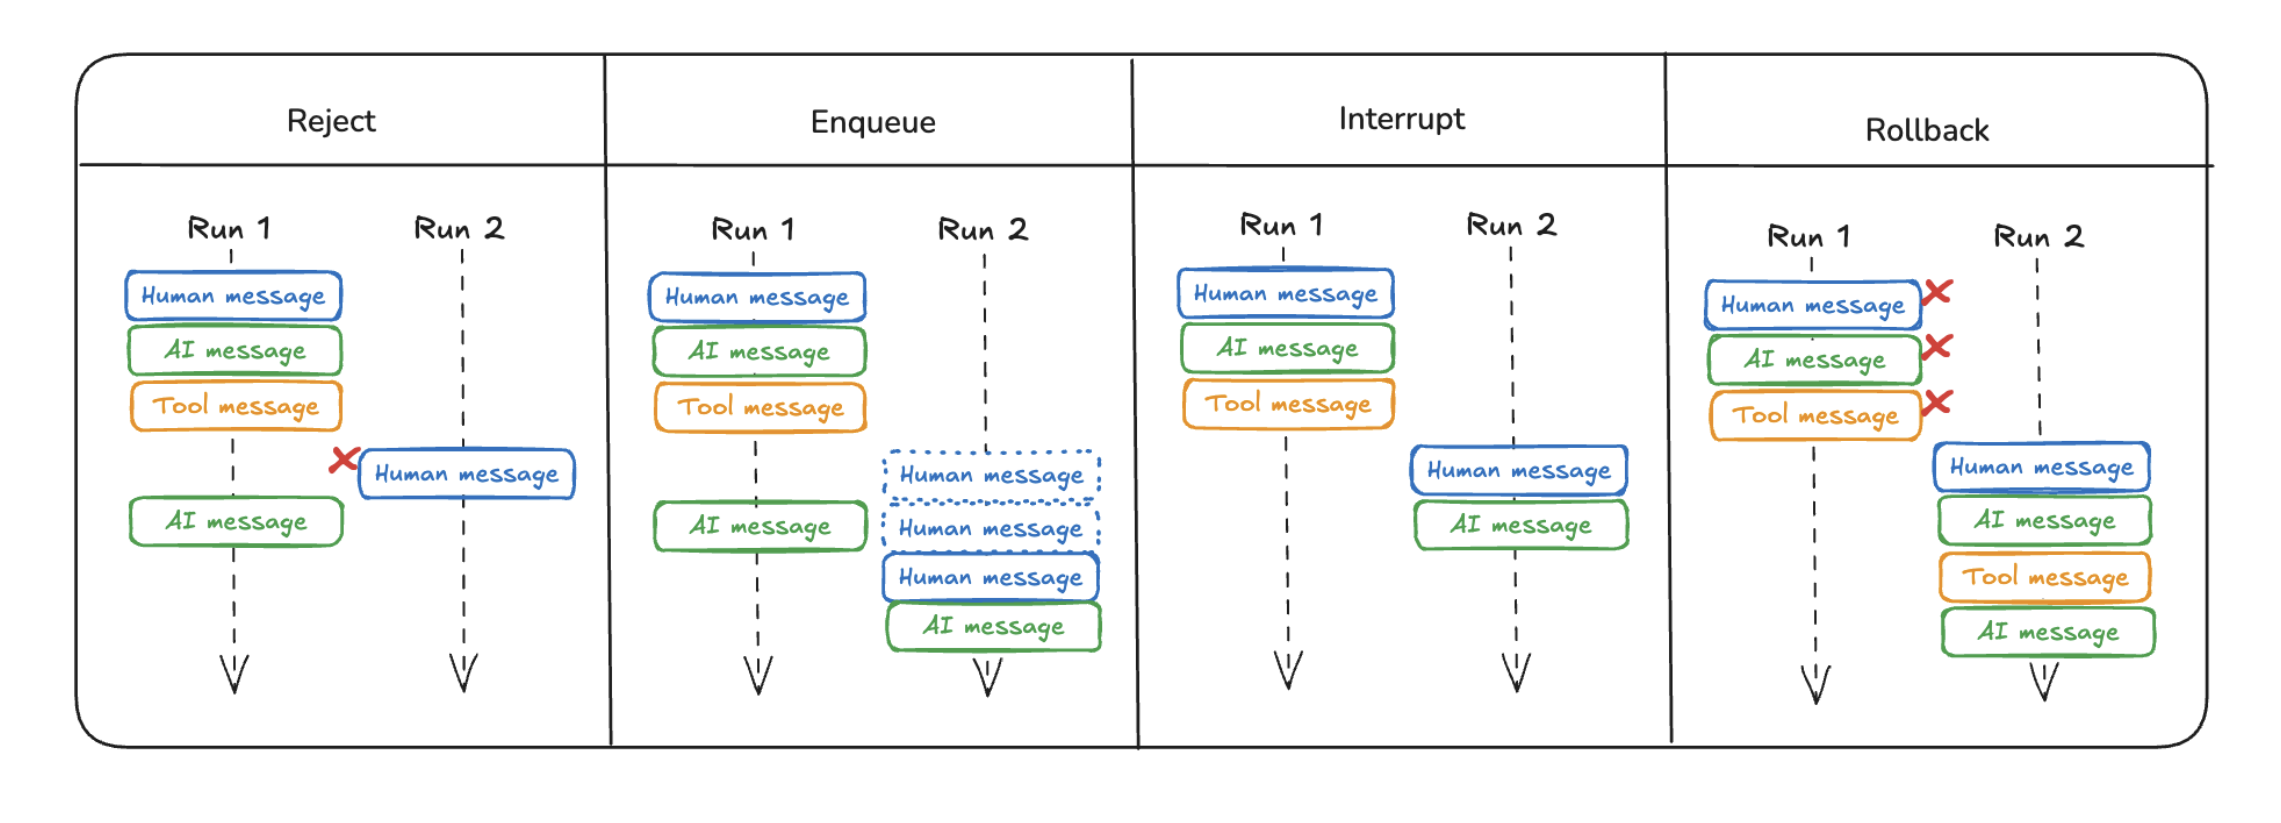